In [62]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [63]:
#Constants
Gna = 30
Gkdr = 15
Gkca = 15
Gkahp = 0.8
Gca = 10
Gl = 0.1
Gc = 2.1 #1.425 
Gnmda = 1.75
Vna = 55
Vk = -75
Vca = 80
Vl = -60
p = 0.5
Ca = 0.21664282 
Cm = 3
betac = 2 
alphac = 0.1
#tau_AMPA = 2
#gAMPA = 1e-0.6
#VAMPA = 0

Isapp = 0.75
Idapp = 0.0

In [64]:
#Alpha and Beta functions and Chi

def H(X):
    if X < 0:
        return 0
    else: 
        return 1

def alphaM(Vs):
    return (0.32*(-46.9 - Vs)/(np.exp((-46.9 - Vs)/4) - 1))

def betaM(Vs):
    return (0.28*(Vs + 19.9)/(np.exp((Vs + 19.9)/5) - 1))

def Minf(Vs):
    return (alphaM(Vs)/(alphaM(Vs) + betaM(Vs)))

def alphaN(Vs):
    return ((0.016*(-24.9 - Vs))/(np.exp((-24.9 - Vs)/5) - 1))

def betaN(Vs):
    return (0.25*np.exp(-1 - 0.025*Vs))

def alphaH(Vs):
    return (0.125*np.exp((-43-Vs)/18))

def betaH(Vs):
    return (4/(1 + np.exp((-20-Vs)/5)))

def alphaS(Vd):
    return (1.6/(1 + np.exp(-0.072*(Vd - 5))))

def betaS(Vd):
    return (0.02*(Vd + 8.9)/(np.exp((Vd + 8.9)/5) - 1))

def alphaC(Vd):
    return ((1 - H(Vd + 10)*np.exp((Vd + 50)/11 - (Vd + 53.5)/27)/18.975) + H(Vd + 10)*(2*np.exp((-53.5-Vd)/27)))

def betaC(Vd):
    return ((1 - H(Vd + 10))*(2*np.exp((-53.5 - Vd)/27) - alphaC(Vd)))

def alphaQ(Ca):
    return (min(0.00002*Ca,0.01))

def betaQ(Ca):
    return (0.001)

#def chi(Ca):
#    return (min(Ca/250.00,1))
    
def qinf(Ca):
    return ((0.7894 * np.exp(0.0002726*Ca)) - (0.7292 * np.exp(-0.01672*Ca)))

def tauq(Ca):
    return (657.9 * np.exp(-0.02023*Ca)) + (301.8 * np.exp(-0.002381*Ca))

def cinf(Vd):
    return ((1.0/(1.0 + np.exp((-10.1 - Vd)/0.1016)))**0.00925)

#def tauc(Vd):
#    return (3.627 * np.exp(0.03704*Vd))

def chi(Ca):
    return (1.073*np.sin(0.003453*Ca+0.08095) \
            + 0.08408*np.sin(0.01634*Ca-2.34)\
            + 0.01811*np.sin(0.0348*Ca-0.9918))


#RK

def dVdt(V, t):
    Vs, Vd, m, n, h, s, c, q, Ca = V
    
    #Equations for currents
    Ina = Gna * (Minf(Vs))**2 * h * (Vs - Vna) #Mi is minfinity
    Ikdr = Gkdr * n * (Vs - Vk)
    Ica = Gca * s**2 * (Vd - Vca)
    Ikca = Gkca * c * chi(Ca) * (Vd - Vk)
    Ikahp = Gkahp * q * (Vd - Vk)
    Isd = Gc * (Vs - Vd)
    Ids = -Isd
    Ileakd = Gl * (Vd - Vl)
    Ileaks = Gl * (Vs - Vl)
    Inmda = Gnmda*(Vd)/(1 + 0.28*np.exp(-0.062*(Vd)))

    dCadt = (-0.13*Ica - 0.075*Ca)
    dvsdt = (-Ileaks - Ina - Ikdr + Ids/p + Isapp/p)/Cm
    dvddt = (-Ileakd - Ica - Ikca - Ikahp + Isd/(1-p) - Inmda/(1-p) + Idapp/(1-p))/Cm
    dmdt = (((alphaM(Vs)/(alphaM(Vs) + betaM(Vs))) - m)/(1/(alphaM(Vs) + betaM(Vs))))
    dndt = (((alphaN(Vs)/(alphaN(Vs) + betaN(Vs))) - n)/(1/(alphaN(Vs) + betaN(Vs))))
    dhdt = (((alphaH(Vs)/(alphaH(Vs) + betaH(Vs))) - h)/(1/(alphaH(Vs) + betaH(Vs))))
    dsdt = (((alphaS(Vd)/(alphaS(Vd) + betaS(Vd))) - s)/(1/(alphaS(Vd) + betaS(Vd))))
    dcdt = (((alphaC(Vd)/(alphaC(Vd) + betaC(Vd))) - c)/(1/(alphaC(Vd) + betaC(Vd))))
    #dqdt = (((alphaQ(Ca)/(alphaQ(Ca) + betaQ(Ca))) - q)/(1/(alphaQ(Ca) + betaQ(Ca))))
    #dqdt = (qinf(Ca) - q)/tauq(Ca)
    #dcdt = (cinf(Vd) - c)/tauc(Vd)
    dqdt = alphaQ(Ca) - (alphaQ(Ca) + betaQ(Ca))*q
    
    
    return dvsdt, dvddt, dmdt, dndt, dhdt, dsdt, dcdt, dqdt, dCadt

In [65]:
tmin, tmax, dt = 0, 1000, 0.01
T = np.arange(tmin,tmax,dt)

V0 = [-62.89223689, -62.98248752, 0.5, 0.00068604, 0.99806345, 0.01086703, 0.00809387, 0.0811213, 0.21664282] #Initital values need to be feeded
sol = odeint(dVdt, V0, T)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


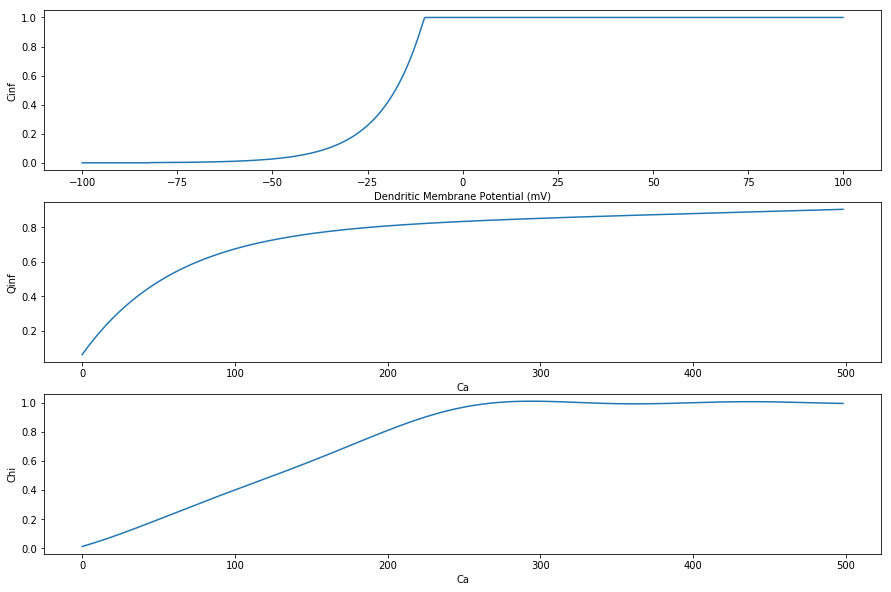

In [66]:
Vdmin, Vdmax, dVd = -100, 100, 0.1
Vd = np.arange(Vdmin,Vdmax,dVd)
Cmin, Cmax, dC = 0, 500, 2
C = np.arange(Cmin, Cmax, dC)
plt.figure(figsize = (15,10))

plt.subplot(3,1,1)
plt.plot(Vd, cinf(Vd))
plt.ylabel('Cinf')
plt.xlabel('Dendritic Membrane Potential (mV)')
plt.legend

plt.subplot(3,1,2)
plt.plot(C, qinf(C))
plt.ylabel('Qinf')
plt.xlabel('Ca')
plt.legend

plt.subplot(3,1,3)
plt.plot(C, [chi(c) for c in C])
plt.ylabel('Chi')
plt.xlabel('Ca')
plt.legend

#plt.savefig('Functions of Cinf_Qinf_Chi.png')
#print qinf(C), cinf(Vd), chi(C)

plt.show()

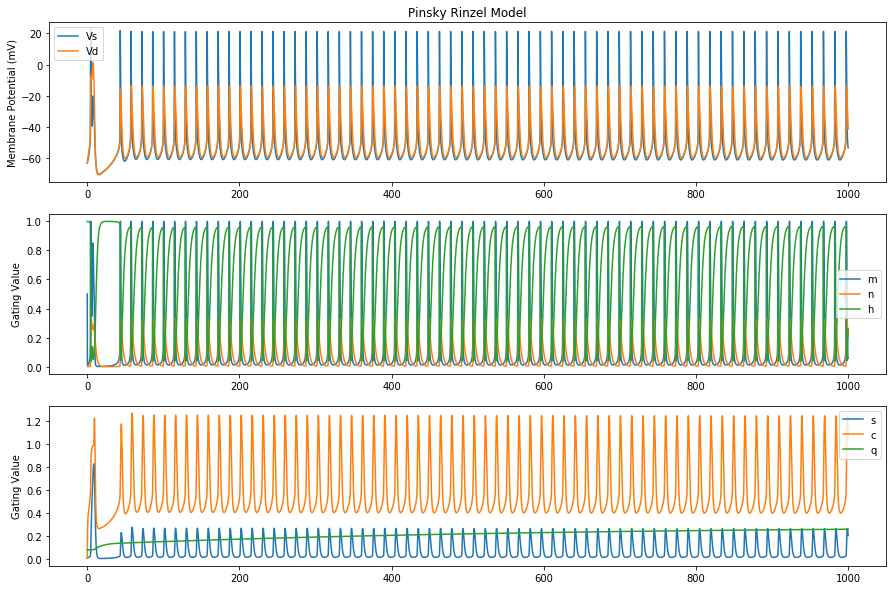

In [67]:
Vs, Vd, m, n, h, s, c, q, Ca = sol.T

plt.figure(figsize=(15, 10))

plt.subplot(3,1,1)
plt.title('Pinsky Rinzel Model')
plt.plot(T, Vs, label = 'Vs')
plt.plot(T, Vd, label = 'Vd')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(T, m, label='m')
plt.plot(T, n, label='n')
plt.plot(T, h, label='h')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(3,1,3)
plt.plot(T, s, label='s')
plt.plot(T, c, label='c')
plt.plot(T, q, label='q')
plt.ylabel('Gating Value')
plt.legend()

#plt.savefig('Dendritic Input, weak coupling.png')

plt.show()

NameError: name 'F' is not defined

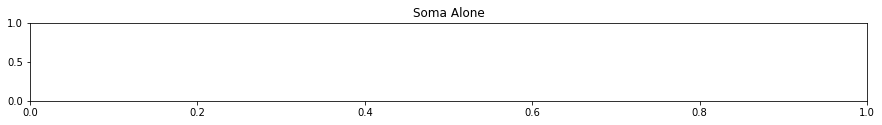

In [18]:
Isapp = np.arange(0, 3, 0.01)
Idapp = np.arange(0, 3, 0.01)
I = np.arange(0, 3, 0.01)
plt.figure(figsize = (15,10))

plt.subplot(6,1,1)
plt.title('Soma Alone')
plt.plot(Isapp,F)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Isapp (uA/cm^2)')
plt.legend

plt.subplot(6,1,2)
plt.title('Dendrite Alone')
plt.plot(Idapp,F)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Idapp (uA/cm^2)')
plt.legend

plt.subplot(6,1,3)
plt.title('Somatic Input')
plt.plot(Isapp,F)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Isapp (uA/cm^2)')
plt.legend

plt.subplot(6,1,4)
plt.title('Dentritic Input')
plt.plot()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Idapp (uA/cm^2)')
plt.legend

plt.subplot(6,1,5)
plt.title('Infinite Gc')
plt.plot()
plt.ylabel('Frequency (Hz)')
plt.xlabel('I (uA/cm^2)')
plt.legend

plt.subplot(6,1,6)
plt.title('Traub Comparision')
plt.plot()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Isapp (uA/cm^2)')
plt.legend

plt.show()